In [1]:
import os
import pandas as pd
import cv2
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Path to the chest-ct-segmentation dataset folder
data_dir = "dataset\Lucchi++"
train_images_dir = os.path.join(data_dir, "Train_In")
train_masks_dir = os.path.join(data_dir, "Train_Out")
test_images_dir = os.path.join(data_dir, "Test_In")
test_masks_dir = os.path.join(data_dir, "Test_Out")

i = 0
# Prepare the training data, Append image and corresponding mask paths
train_data = []
for image_file in os.listdir(train_images_dir):
    image_path = os.path.join(train_images_dir, image_file)
    mask_path = os.path.join(train_masks_dir, f"{i}.png")
    i += 1
    train_data.append(
    { 
        "image" : image_path, 
        "annotation" : mask_path
    })

i = 0
# Prepare the test data, Append image and corresponding mask paths
test_data = []
for image_file in os.listdir(test_images_dir):
    image_path = os.path.join(test_images_dir, image_file)
    mask_path = os.path.join(test_masks_dir, f"{i}.png")
    i += 1
    test_data.append(
    { 
        "image" : image_path, 
        "annotation" : mask_path
    })
print(train_data)

[{'image': 'dataset\\Lucchi++\\Train_In\\mask0000.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\0.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0001.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\1.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0002.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\2.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0003.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\3.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0004.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\4.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0005.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\5.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0006.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\6.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0007.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\7.png'}, {'image': 'dataset\\Lucchi++\\Train_In\\mask0008.png', 'annotation': 'dataset\\Lucchi++\\Train_Out\\8.png'}, {'image': 'dataset

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage import measure

def read_batch(data, visualize_data=False):
    # 選擇隨機條目
    ent = data[np.random.randint(len(data))]

    # 讀取圖像
    Img = cv2.imread(ent["image"])[..., ::-1]  # 轉換BGR為RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # 以灰度圖讀取註釋

    if Img is None or ann_map is None:
        print(f"錯誤：無法從路徑 {ent['image']} 或 {ent['annotation']} 讀取圖像或遮罩")
        return None, None, None, 0

    # 調整圖像和遮罩大小
    r = min(1024 / Img.shape[1], 1024 / Img.shape[0])  # 縮放因子
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # 初始化二值遮罩
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)

    # 獲取二值遮罩並合併為單一遮罩
    inds = np.unique(ann_map)[1:]  # 跳過背景（索引0）
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # 為每個唯一索引創建二值遮罩
        binary_mask = np.maximum(binary_mask, mask)  # 與現有二值遮罩合併

    # 腐蝕合併的二值遮罩以避免邊界點
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # 使用連通區域分析來找到所有獨立的白色區域
    labels = measure.label(eroded_mask)
    regions = measure.regionprops(labels)

    points = []
    for region in regions:
        # 為每個區域選擇一個隨機點
        y, x = region.coords[np.random.randint(len(region.coords))]
        points.append([x, y])  # 注意：我們存儲為 [x, y] 以與原始代碼保持一致

    points = np.array(points)

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # 現在形狀是 (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)

    # 返回圖像、二值化遮罩、點和遮罩數量
    return Img, binary_mask, points, len(inds)


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage import measure
from skimage.morphology import remove_small_objects, disk
from scipy.ndimage import binary_dilation, binary_erosion

# 可修改的參數
MIN_SIZE = 100    # 移除小於此尺寸的白色區域
SELEM_RADIUS = 3  # 形態學操作中圓形結構元素的半徑

def read_batch_speical(Img, ann_map, visualize_data=False):
    # 調整圖像和遮罩大小
    r = min(1024 / Img.shape[1], 1024 / Img.shape[0])  # 縮放因子
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # 初始化二值遮罩
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)

    # 獲取二值遮罩並合併為單一遮罩
    inds = np.unique(ann_map)[1:]  # 跳過背景（索引0）
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)
        binary_mask = np.maximum(binary_mask, mask)

    # 先进行后处理
    # 1. 移除小物体
    cleaned_mask = remove_small_objects(binary_mask.astype(bool), min_size=MIN_SIZE, connectivity=2)
    
    # 2. 创建圆形结构元素并进行闭运算
    selem = disk(SELEM_RADIUS)
    processed_mask = binary_erosion(binary_dilation(cleaned_mask, selem), selem)
    
    # 3. 腐蝕處理過的遮罩以避免邊界點
    eroded_mask = cv2.erode(processed_mask.astype(np.uint8), np.ones((5, 5), np.uint8), iterations=1)

    # 使用連通區域分析來找到所有獨立的白色區域
    labels = measure.label(eroded_mask)
    regions = measure.regionprops(labels)

    points = []
    for region in regions:
        # 使用区域质心作为点位置
        y, x = region.centroid
        # 将质心四舍五入到最近的整数坐标
        x, y = int(round(x)), int(round(y))
        
        # 确保点在区域内部
        if eroded_mask[y, x] == 0:
            # 如果质心不在区域内，找到最近的区域内点
            coords = region.coords
            distances = np.sqrt((coords[:, 0] - y)**2 + (coords[:, 1] - x)**2)
            nearest_idx = np.argmin(distances)
            y, x = coords[nearest_idx]
        
        points.append([x, y])

    points = np.array(points)

    if visualize_data:
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask after Morphological Operations
        plt.subplot(1, 3, 2)
        plt.title('Mask after Morphological Operations')
        plt.imshow(processed_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points
        plt.subplot(1, 3, 3)
        plt.title('Mask with Points')
        plt.imshow(processed_mask, cmap='gray')
        
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100)

        plt.axis('off')
        plt.tight_layout()
        plt.show()

    # 使用处理过的mask作为返回值
    binary_mask = processed_mask.astype(np.uint8)
    binary_mask = np.expand_dims(binary_mask, axis=-1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)

    return Img, binary_mask, points, len(inds)

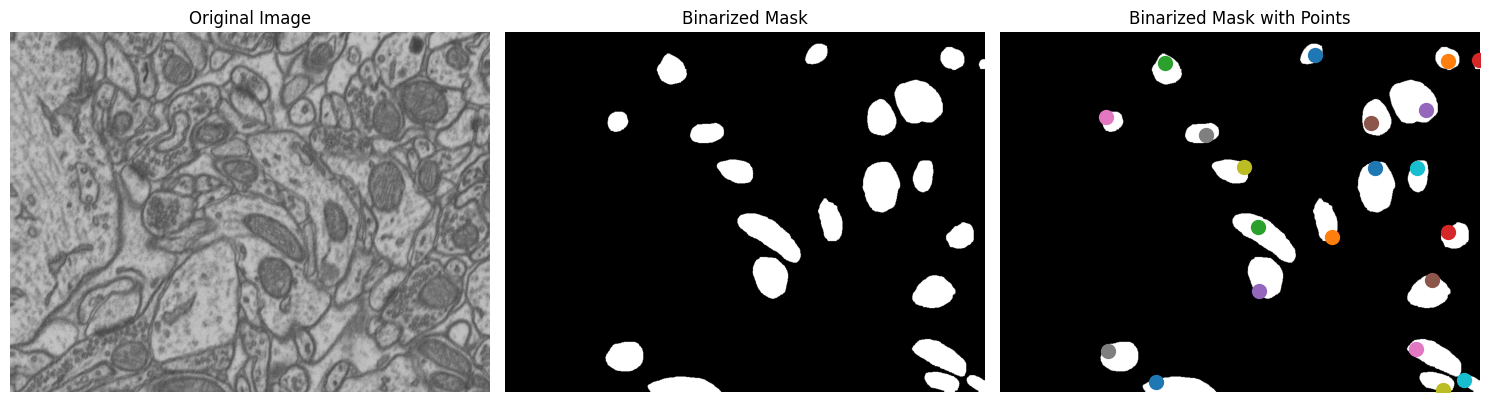

In [4]:
# Visualize the data
Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

In [124]:
device = "cuda" if torch.cuda.is_available() else "cpu"

sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, sam2_checkpoint, device=device))

# 開始訓練

In [125]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 1000 # @param 

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"

In [126]:
# Initialize scheduler
from torch import tensor


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1
accumulation_steps = 4  # Number of steps to accumulate gradients before updating

for step in range(1, NO_OF_STEPS + 1):
    with torch.cuda.amp.autocast():
        image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)
        if image is None or mask is None or num_masks == 0:
            continue

        input_label = np.ones((num_masks, 1))
        if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
            continue

        if input_point.size == 0 or input_label.size == 0:
            continue

        predictor.set_image(image)
        mask_input, ucc, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
        if ucc is None or labels is None or ucc.shape[0] == 0 or labels.shape[0] == 0:
            continue
        # print(ucc)
        # Loop through the tensor
        for i in range(ucc.shape[0]):
            # Extract a [1, 2, 256] slice
            uc = ucc[i:i+1, :, :]
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                points=(uc, labels), boxes=None, masks=None,
            )

            batched_mode = uc.shape[0] > 1
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=True,
                repeat_image=batched_mode,
                high_res_features=high_res_features,
            )
            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            prd_mask = torch.sigmoid(prd_masks[:, 0])
            seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
            score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
            loss = seg_loss + score_loss * 0.05

            # Apply gradient accumulation
            loss = loss / accumulation_steps
            scaler.scale(loss).backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

            if step % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                predictor.model.zero_grad()

            # Update scheduler
            scheduler.step()

        if step % 500 == 0:
            FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
            torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

        if step == 1:
            mean_iou = 0

        mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

        if step % 100 == 0:
            print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)

d:\python\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\MHA.cpp:676.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
d:\python\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Step 100:	 Accuracy (IoU) =  0.2187698851866522
Step 200:	 Accuracy (IoU) =  0.47058874683652513
Step 300:	 Accuracy (IoU) =  0.5658229702121012
Step 400:	 Accuracy (IoU) =  0.5944466564209808
Step 500:	 Accuracy (IoU) =  0.6122394516019402
Step 600:	 Accuracy (IoU) =  0.6177708237563997
Step 700:	 Accuracy (IoU) =  0.6199096610606813
Step 800:	 Accuracy (IoU) =  0.6326591195976393
Step 900:	 Accuracy (IoU) =  0.5974723435269063
Step 1000:	 Accuracy (IoU) =  0.6082637581803028


# 開始推理

In [5]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

# testtting

In [6]:
# Randomly select a test image from the test_data
import random


selected_entry = random.choice(test_data)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']

print(mask_path)

# Load the selected image and mask
image, mask = read_image(image_path, mask_path)

org_mask = mask

# Generate random points for the input
num_samples = 2  # Number of points per segment to sample
input_points = get_points(mask, num_samples)

# Load the fine-tuned model
# FINE_TUNED_MODEL_WEIGHTS = "fine_tuned_sam2_2000_old.torch"
sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "configs/sam2/sam2_hiera_l.yaml"
# Build net and load weights
predictor = SAM2ImagePredictor(build_sam2(model_cfg, sam2_checkpoint, device="cuda"))
#predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

# count lou


dataset\Lucchi++\Test_Out\6.png


f:\github\segment-anything-2\sam2\modeling\backbones\hieradet.py:70: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(
f:\github\segment-anything-2\sam2\modeling\sam\transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:723.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
f:\github\segment-anything-2\sam2\modeling\sam\transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)

# UNET + SAM =>>>

In [7]:
import torch
import torch.nn as nn
class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationModel, self).__init__()
        
        # Encoder (downsampling)
        self.encoder = nn.Sequential(
            self.conv_block(3, 32, stride=2),
            self.conv_block(32, 64, stride=2),
            self.conv_block(64, 128, stride=2),
            self.conv_block(128, 256, stride=2)
        )
        
        # Decoder (upsampling)
        self.decoder = nn.Sequential(
            self.upconv_block(256, 128),
            self.upconv_block(128, 64),
            self.upconv_block(64, 32),
            self.upconv_block(32, 32)
        )
        
        # Final classification layer
        self.final = nn.Conv2d(32, num_classes, kernel_size=3, padding=1)
        
    def conv_block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        features = []
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            features.append(x)
        
        # Decoder
        for i, decoder_layer in enumerate(self.decoder):
            x = decoder_layer(x)
            if i < len(self.decoder) - 1:
                x = x + features[-i-2]  # Skip connection
        
        # Final classification
        x = self.final(x)
        return x

In [8]:
# load from oxford_segmentation_models.pth
import torch

def load_model(model_path, num_classes, device):
    # Create an instance of your model
    model = SegmentationModel(num_classes)
    
    # Load the state dict
    state_dict = torch.load(model_path, map_location=device)
    
    # Load the state dict into your model
    model.load_state_dict(state_dict)
    
    # Move the model to the specified device
    model = model.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

# # Usage
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# num_classes = 1 
# model_path = "simple_unet_segmentation.pth"

# model = load_model(model_path, num_classes, device)

In [9]:
# Load the selected image and mask
image, mask_2 = read_image(image_path, mask_path)

# Build net and load weights from orignal SAM2
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

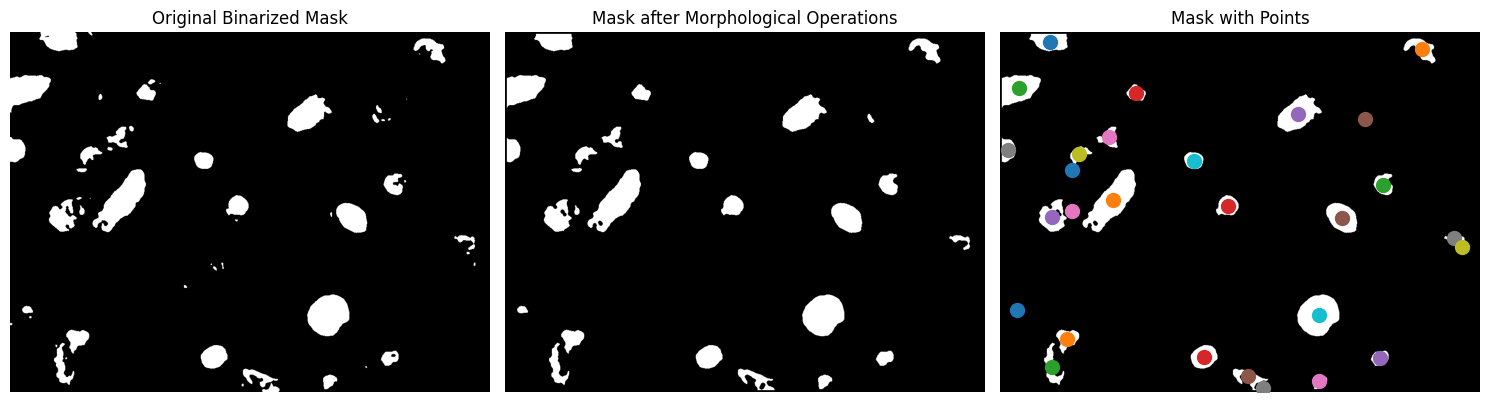

In [ ]:
# 可修改的參數
PATCH_SIZE = 512  # Patch大小,影響分割精度和速度。更大的patch可能提高精度,但會增加計算時間。
MIN_SIZE = 125  # 移除小於此尺寸的白色區域。更大的值會移除更多的小區域。
SELEM_RADIUS = 4  # 形態學操作中圓形結構元素的半徑。更大的半徑會導致更多的平滑。
OVERLAP_THRESHOLD = 0.15  # 用於判斷是否保留重疊區域的閾值。更高的值會保留更多的重疊區域。

# 加载训练好的分割模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 1 
model_path = "overlaping_unet_segmentation.pth"
model = load_model(model_path, num_classes, device)

# 使用模型预测获取mask
def get_prediction_mask(model, image, device="cuda"):
    model.eval()

    # Load and preprocess image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (1024, 768))
    
    # Parameters for overlapping patches
    patch_size = PATCH_SIZE
    overlap = patch_size // 2  # 50% overlap
    
    # Calculate steps with overlap
    h_steps = int(np.ceil((768 - patch_size) / (patch_size - overlap))) + 1
    w_steps = int(np.ceil((1024 - patch_size) / (patch_size - overlap))) + 1
    
    patches_list = []
    patch_positions = []  # Store positions for reconstruction
    
    # Extract overlapping patches
    for i in range(h_steps):
        for j in range(w_steps):
            # Calculate patch coordinates with overlap
            y_start = min(i * (patch_size - overlap), 768 - patch_size)
            x_start = min(j * (patch_size - overlap), 1024 - patch_size)
            
            # Extract patch
            patch = image[y_start:y_start+patch_size, x_start:x_start+patch_size]
            
            # 标准化并转换通道顺序
            patch = patch / 255.0
            patch = patch.transpose(2, 0, 1)  # (H,W,C) -> (C,H,W)
            patches_list.append(patch)
            patch_positions.append((y_start, x_start))
    
    # Convert to tensors
    patches_array = np.stack(patches_list)
    patches_tensor = torch.from_numpy(patches_array).float().to(device)
    
    # Run inference
    with torch.no_grad():
        outputs = model(patches_tensor)
        pred_masks = torch.sigmoid(outputs) > 0.5
    
    # Initialize weight and prediction maps
    weight_map = np.zeros((768, 1024))
    pred_map = np.zeros((768, 1024))
    
    # Create Gaussian weight kernel for smooth blending
    y, x = np.mgrid[0:patch_size, 0:patch_size]
    weight_kernel = np.exp(-((x - patch_size/2)**2 + (y - patch_size/2)**2) / (2*(patch_size/4)**2))
    
    # Reconstruct full mask with weighted averaging
    for idx, (y_start, x_start) in enumerate(patch_positions):
        mask_patch = pred_masks[idx, 0].cpu().numpy()
        
        # Apply weight kernel
        weighted_patch = mask_patch * weight_kernel
        
        # Add to prediction and weight maps
        y_end = min(y_start + patch_size, 768)
        x_end = min(x_start + patch_size, 1024)
        h, w = y_end - y_start, x_end - x_start
        
        pred_map[y_start:y_end, x_start:x_end] += weighted_patch[:h, :w]
        weight_map[y_start:y_end, x_start:x_end] += weight_kernel[:h, :w]
    
    # Normalize by weights and threshold
    full_mask = np.divide(pred_map, weight_map, where=weight_map > 0)
    full_mask = (full_mask > 0.5).astype(np.float32)
    
    return full_mask

# 获取预测的mask
predicted_mask = get_prediction_mask(model, image)

from skimage.morphology import remove_small_objects, disk
from scipy.ndimage import binary_dilation, binary_erosion

# Build net and load weights
predictor2 = SAM2ImagePredictor(sam2_model)

# Generate random points for the input
_, _, input_points, _ = read_batch_speical(image, predicted_mask, True)

# Perform inference and predict masks
# 用box(整個圖像)的形式輸入prompt
with torch.no_grad():
   predictor2.set_image(image)
   masks, scores, logits = predictor2.predict(
      point_coords=input_points,
      point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks_2 = np.array(masks[:, 0])
np_scores_2 = scores[:, 0]
sorted_masks_2 = np_masks_2[np.argsort(np_scores_2)][::-1]

# Initialize segmentation map and occupancy mask
occupancy_mask_2 = np.zeros_like(sorted_masks_2[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks_2.shape[0]):
   mask_2 = sorted_masks_2[i]
   if (mask_2 * occupancy_mask_2).sum() / mask_2.sum() > OVERLAP_THRESHOLD:
       continue

   mask_bool_2 = mask_2.astype(bool)
   mask_bool_2[occupancy_mask_2] = False  # Set overlapping areas to False in the mask
   occupancy_mask_2[mask_bool_2] = True  # Update occupancy_mask

# 移除小的白色區域
seg_map2_cleaned = remove_small_objects(occupancy_mask_2, min_size=MIN_SIZE, connectivity=2)

# 創建圓形結構元素
selem = disk(SELEM_RADIUS)

# 執行閉運算 (先膨脹後腐蝕)
seg_map2_closed = binary_erosion(binary_dilation(seg_map2_cleaned, selem), selem)

# 將 seg_map2_closed 轉換回原始數據類型
seg_map2_final = np.zeros_like(seg_map2_closed, dtype=np.uint8)

# 給mask上色
for i in range(sorted_masks_2.shape[0]):
    mask_2 = sorted_masks_2[i]
    mask_bool_2 = mask_2.astype(bool)
    mask_bool_2 = mask_bool_2 & seg_map2_closed  # 只保留在 seg_map2_closed 中的白色區域
    seg_map2_final[mask_bool_2] = i + 1

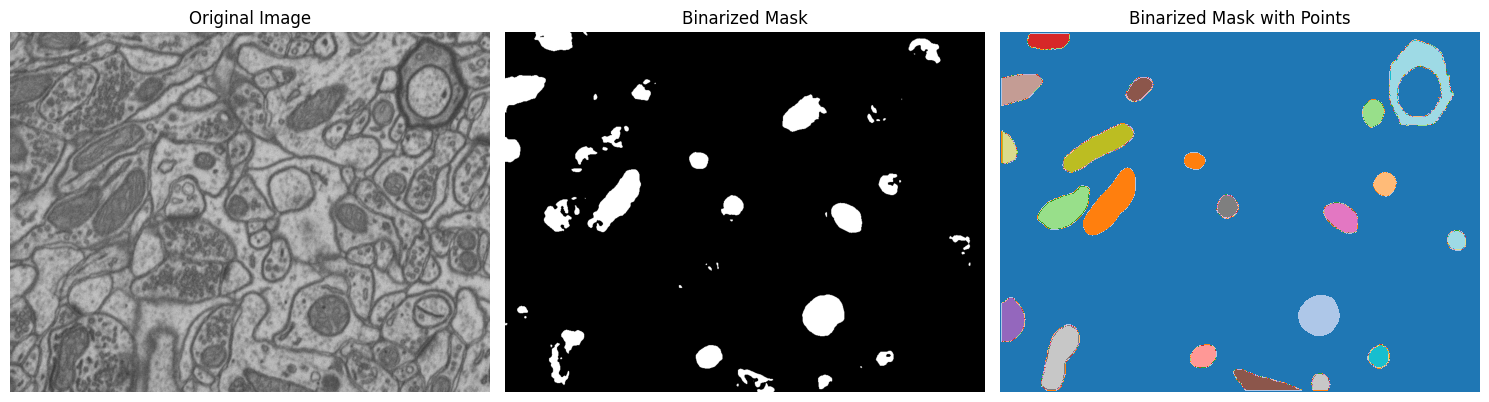

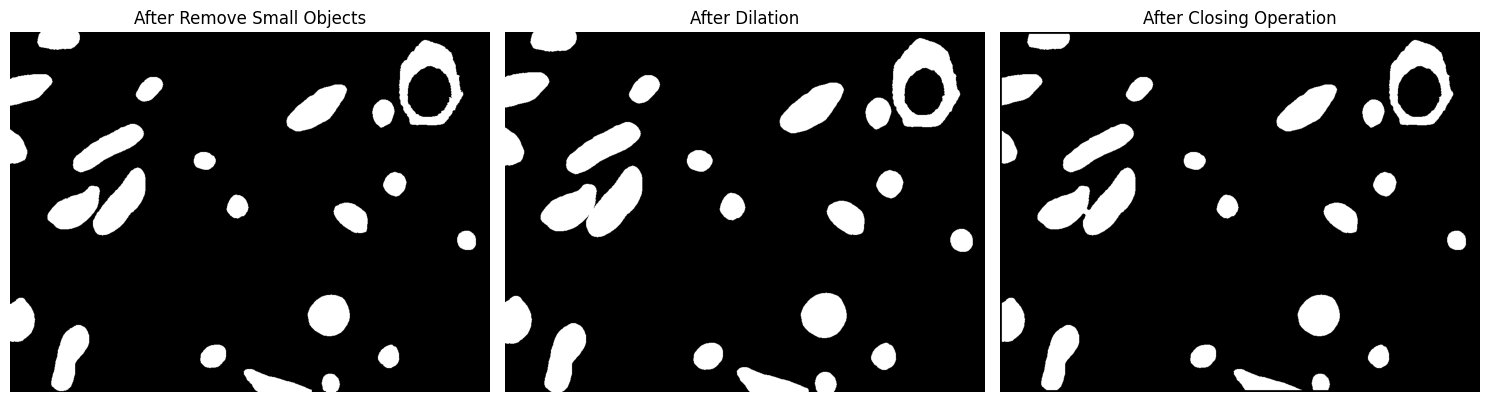

In [11]:
import matplotlib.pyplot as plt

# 设置图像显示大小
plt.figure(figsize=(15, 5))

# 显示原始图像
plt.subplot(131)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# 显示二值化mask
plt.subplot(132)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Binarized Mask')
plt.axis('off')

# 显示带颜色标记的最终分割结果
plt.subplot(133)
plt.imshow(seg_map2_final, cmap='tab20')  # 使用tab20颜色图来显示不同的标签
plt.title('Binarized Mask with Points')
plt.axis('off')

plt.tight_layout()
plt.show()

# 如果想看中间过程的结果，也可以添加如下代码：
plt.figure(figsize=(15, 5))

# 显示清理小物体后的结果
plt.subplot(131)
plt.imshow(seg_map2_cleaned, cmap='gray')
plt.title('After Remove Small Objects')
plt.axis('off')

# 显示膨胀操作后的结果
plt.subplot(132)
plt.imshow(binary_dilation(seg_map2_cleaned, selem), cmap='gray')
plt.title('After Dilation')
plt.axis('off')

# 显示最终的闭运算结果
plt.subplot(133)
plt.imshow(seg_map2_closed, cmap='gray')
plt.title('After Closing Operation')
plt.axis('off')     

plt.tight_layout()
plt.show()

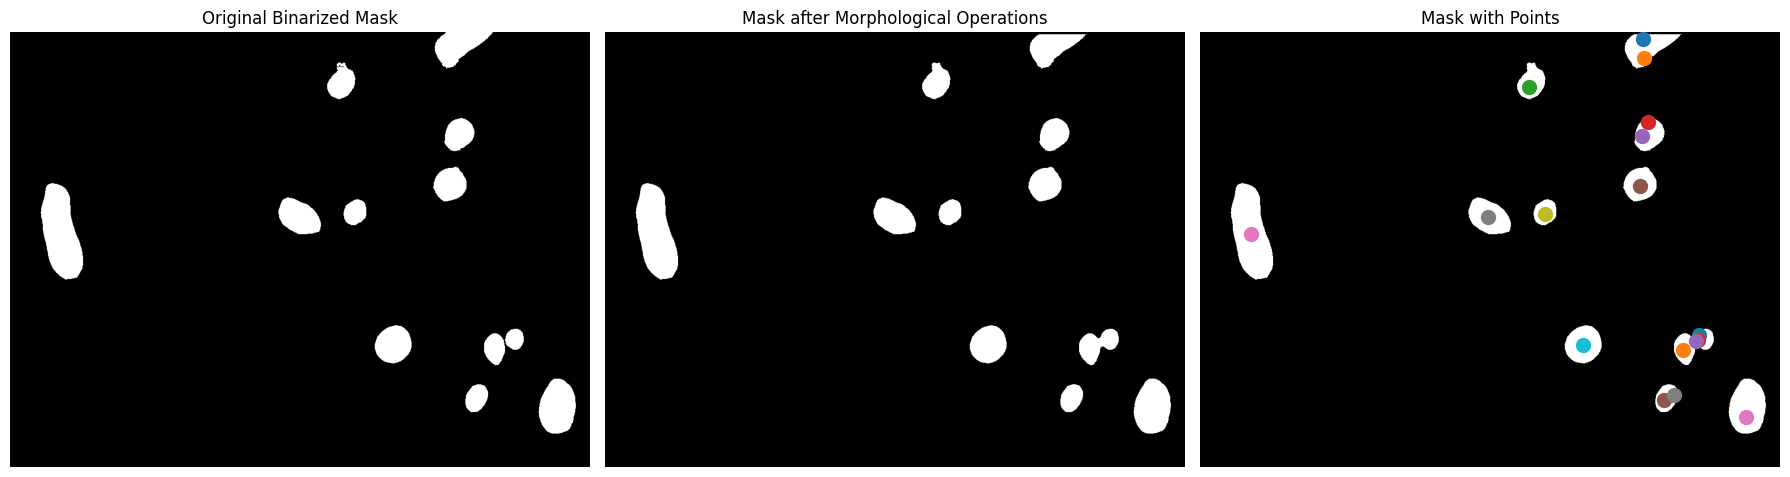

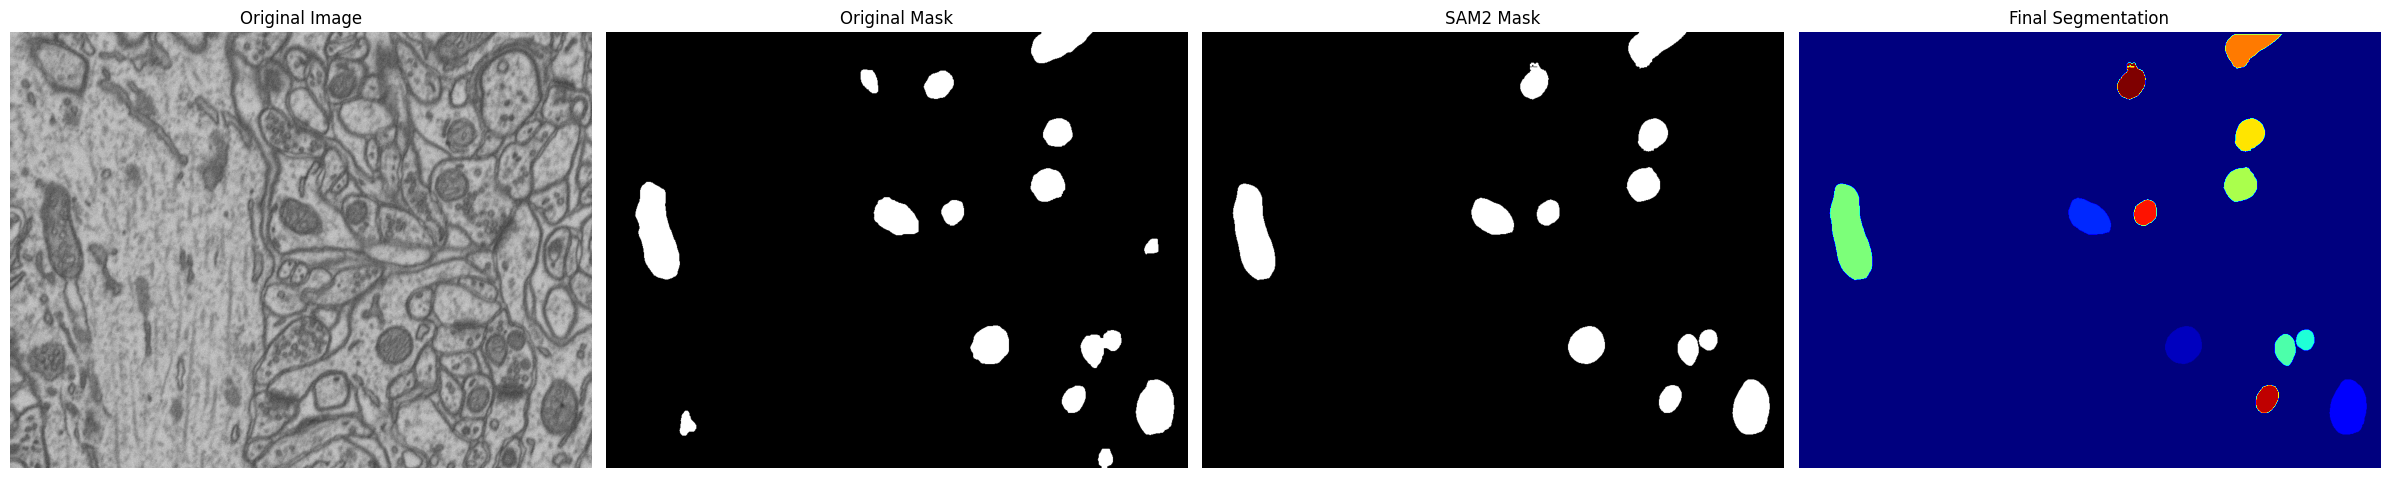

In [183]:
# Visualization Part 1: Show the original binarized mask, mask after morphological operations, and mask with points
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Original Binarized Mask')
plt.imshow(occupancy_mask_2, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Mask after Morphological Operations')
plt.imshow(seg_map2_closed, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Mask with Points')
plt.imshow(seg_map2_closed, cmap='gray')

# Plot points in different colors
colors = list(mcolors.TABLEAU_COLORS.values())
for i, point in enumerate(input_points):
    plt.scatter(point[0][0], point[0][1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')

plt.axis('off')

plt.tight_layout()
plt.show()

# Visualization Part 2: Show the original image, original mask, SAM2 mask, and final segmentation
plt.figure(figsize=(24, 6))

plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Original Mask')
plt.imshow(org_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('SAM2 Mask')
plt.imshow(occupancy_mask_2, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Final Segmentation')
plt.imshow(seg_map2_final, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()